In [106]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv('mercedes-benz-greener-manufacturing/train.csv')
df_train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_test = pd.read_csv('mercedes-benz-greener-manufacturing/test.csv')
df_test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
oe = preprocessing.OrdinalEncoder()

encoder = df_train.drop(['y','ID'], axis=1)
encoder1 = encoder.select_dtypes(exclude='int64')

encoder1 = oe.fit_transform(encoder1)
encoder2 = encoder.select_dtypes(include='int64')

encodedvals = np.append(encoder1,encoder2,axis=1)

encodedframe = pd.DataFrame(encodedvals.astype('int'))
encodedframe.head()

,0,1,2,3,4,5,6,7,8,9,...,366,367,368,369,370,371,372,373,374,375
0,32,23,17,0,3,24,9,14,0,0,...,0,0,1,0,0,0,0,0,0,0
1,32,21,19,4,3,28,11,14,0,0,...,1,0,0,0,0,0,0,0,0,0
2,20,24,34,2,3,27,9,23,0,0,...,0,0,0,0,0,0,1,0,0,0
3,20,21,34,5,3,27,11,4,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20,23,34,5,3,12,3,13,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

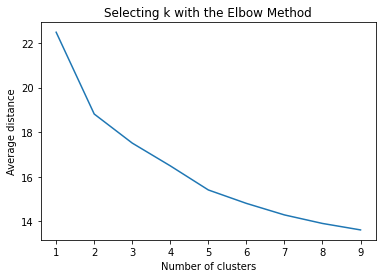

In [9]:
clusters=range(1,10)
meandist=[]

data = encodedframe
# loop through each cluster and fit the model to the train set
# generate the predicted cluster assingment and append the mean 
# distance my taking the sum divided by the shape
for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(data)
    clusassign=model.predict(data)
    meandist.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1))
    / data.shape[0])

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method') 

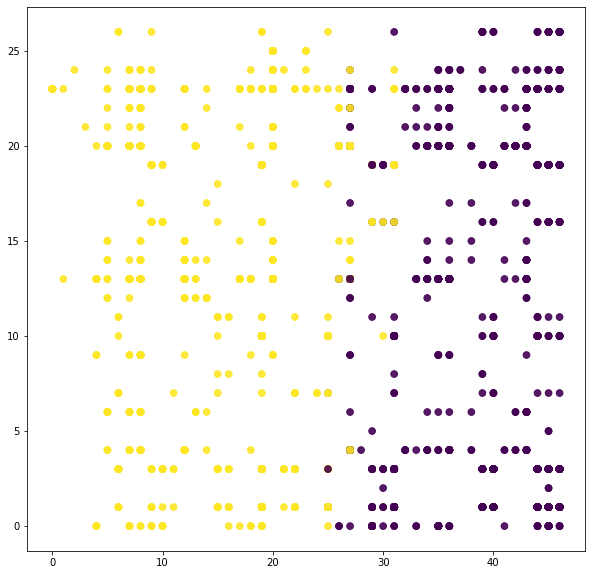

In [13]:
k = KMeans(n_clusters=2, random_state=0)
kfit = k.fit(data)
kpred = kfit.predict(data)
plt.figure(figsize=(10,10))
plt.scatter(data.values[:, 0], data.values[:, 1], c=kpred, s=45, alpha=0.9)

In [16]:
encodedframe['KLabels'] = pd.Series(kpred, index=encodedframe.index)
encodedframe['ID'] = df_train['ID']
encodedframe['y'] = df_train['y']

In [23]:
label = []
for x in range(2):
    label.append(encodedframe.loc[encodedframe['KLabels']==x])

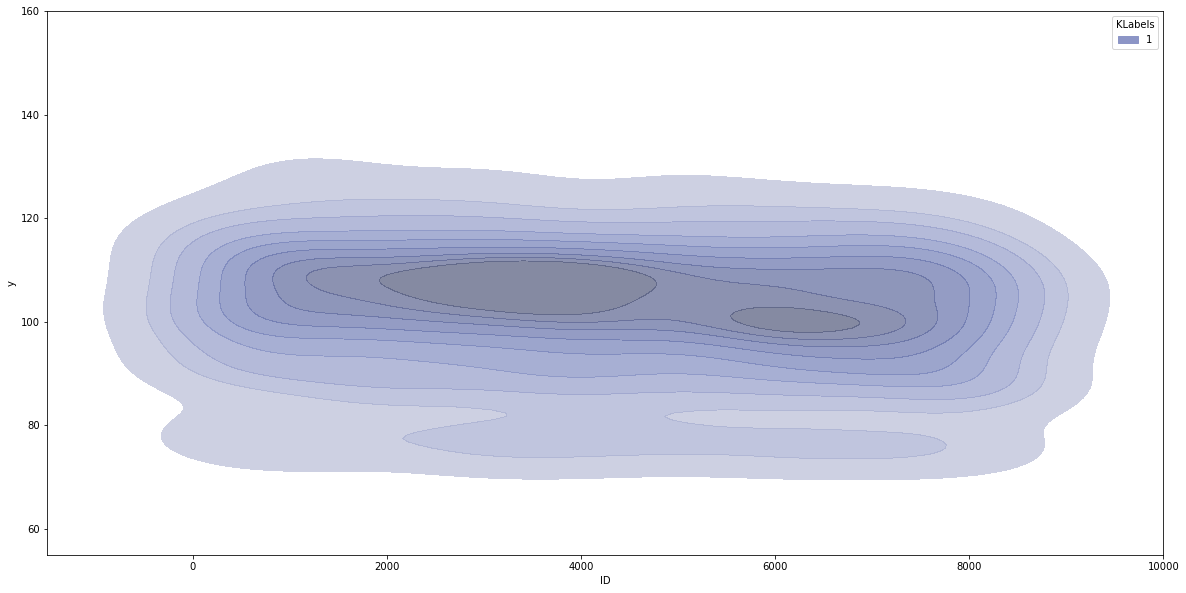

In [25]:
plt.figure(figsize=(20,10))
sns.kdeplot(data=label[1], x='ID', y='y', hue='KLabels', levels=10, palette='BuPu', fill=True, alpha=0.7)
plt.ylim([55,160])
plt.xlim([-1500,10000])
plt.show()

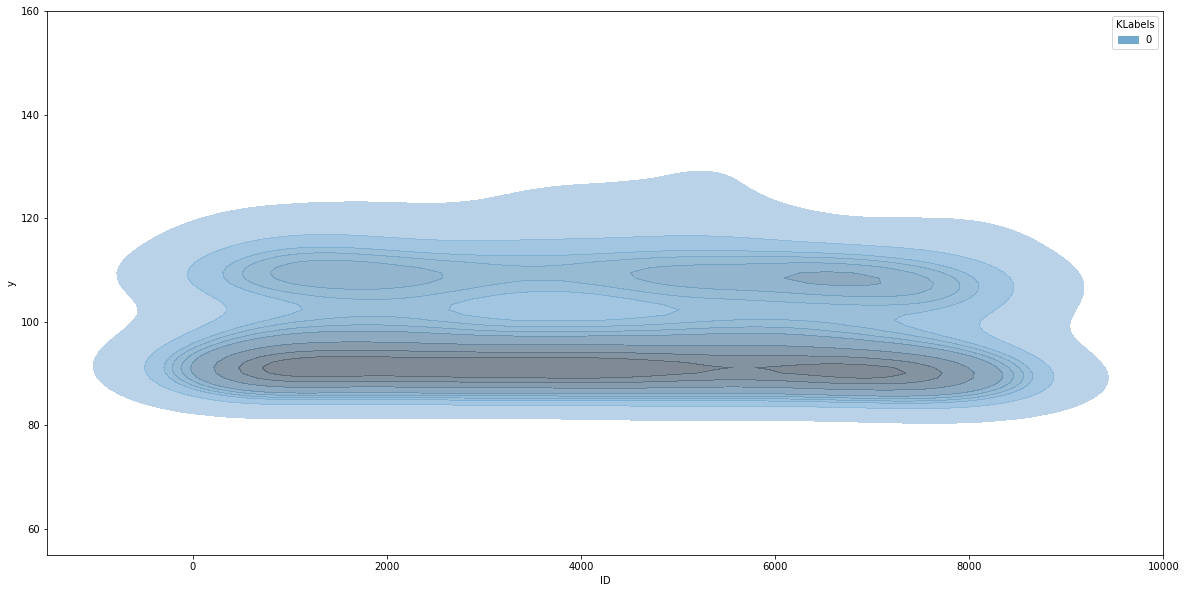

In [27]:
plt.figure(figsize=(20,10))
sns.kdeplot(data=label[0], x='ID', y='y', hue='KLabels', levels=10, palette='PuBu', fill=True, alpha=0.7)
plt.ylim([55,160])
plt.xlim([-1500,10000])
plt.show()

<AxesSubplot:xlabel='ID', ylabel='y'>

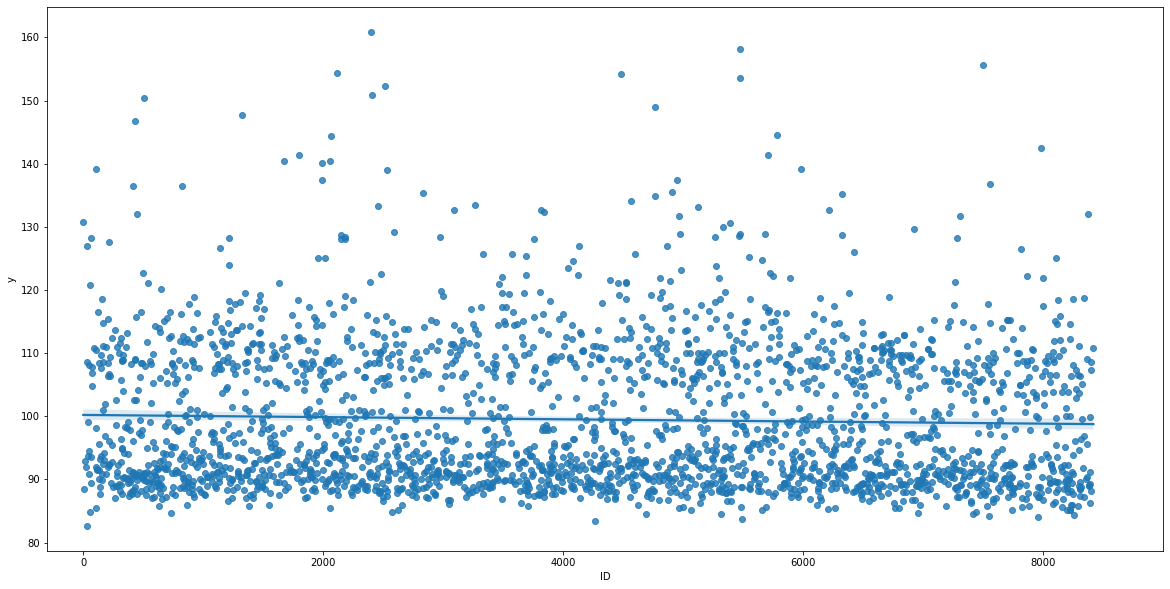

In [69]:
plt.figure(figsize=(20,10))
plt.xlim([-300,9000])
sns.regplot(data=label[0], x='ID', y='y') #found outlier

In [68]:
label[0] = label[0].drop(label[0].loc[label[0]['y'] > 250].index) #drop outlier

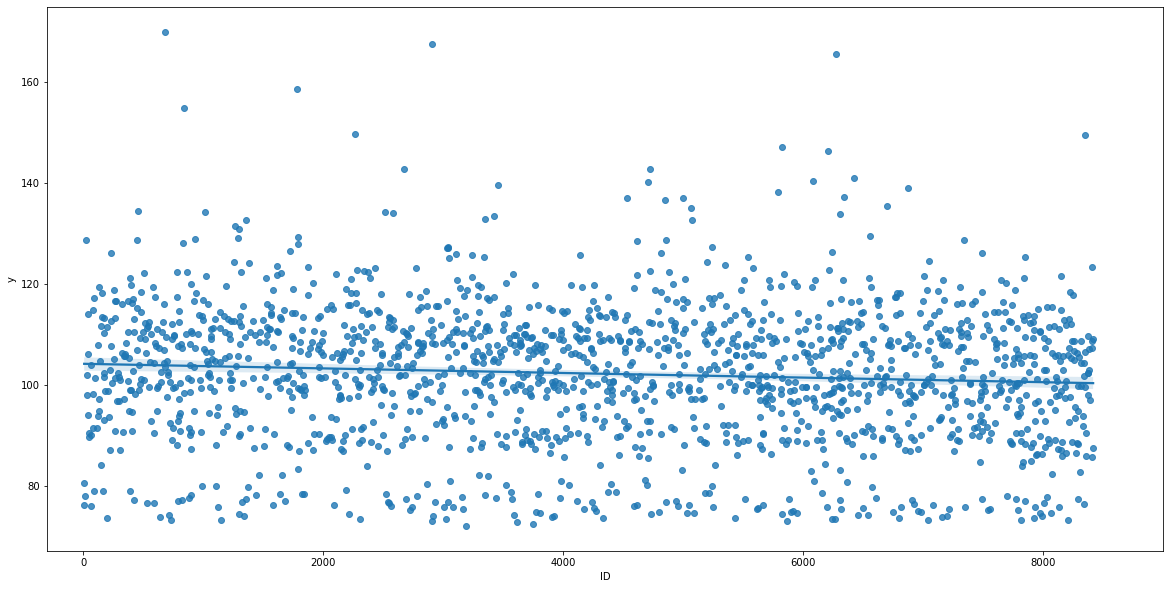

In [40]:
plt.figure(figsize=(20,10))
plt.xlim([-300,9000])
sns.regplot(data=label[1], x='ID', y='y')
plt.show()

In [83]:
clabel = []
for frame in label:
    cframe = pd.DataFrame()
    for column in frame:
        if len((frame[column].value_counts())) == 1:
            print("not_ok")
        else:
            print('ok')
            cframe = pd.concat([cframe,frame[column]],axis=1)
    clabel.append(cframe)  

ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
ok
ok
ok
ok
ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
ok
ok
ok
ok
ok
not_ok
ok
ok
ok
ok
ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
ok
ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
not_ok
ok
not_ok
ok
ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
ok
ok
not_ok
ok
ok
ok
not_ok
not_ok
ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
ok
ok
ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
not_ok
ok
not_ok
not_ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
not_ok
ok
ok
ok
ok
not_ok
not_ok
ok
ok
ok
ok
not_ok
ok
ok
ok
ok
not_ok
not_ok
not_ok
not_ok
not_ok
ok
not_ok
ok
not_ok
not_ok
not_ok
not_ok
not_ok
n

In [84]:
clabel[0]

,0,1,2,3,4,5,6,7,8,10,...,366,367,368,370,371,373,374,375,ID,y
0,32,23,17,0,3,24,9,14,0,0,...,0,0,1,0,0,0,0,0,0,130.81
1,32,21,19,4,3,28,11,14,0,0,...,1,0,0,0,0,0,0,0,6,88.53
5,40,3,25,2,3,11,7,18,0,0,...,0,0,1,0,0,0,0,0,18,92.93
7,36,13,16,5,3,10,9,0,0,0,...,0,0,0,0,0,0,0,0,25,91.91
8,43,20,16,4,3,10,8,7,0,0,...,1,0,0,0,0,0,0,0,27,108.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4197,46,23,3,2,3,0,3,17,0,0,...,1,0,0,0,0,0,0,0,8392,89.25
4199,40,1,21,2,3,0,11,14,1,0,...,1,0,0,0,0,0,0,0,8395,88.24
4200,46,1,25,2,3,0,8,22,0,0,...,1,0,0,0,0,0,0,0,8397,108.59
4201,43,23,40,3,3,0,7,6,0,0,...,0,1,0,0,0,0,0,0,8399,107.39


In [87]:
test_encoder = df_test.drop(['ID'], axis=1)
test_encoder1 = test_encoder.select_dtypes(exclude='int64')

test_encoder1 = oe.fit_transform(test_encoder1)
test_encoder2 = test_encoder.select_dtypes(include='int64')

test_encodedvals = np.append(test_encoder1,test_encoder2,axis=1)

test_encodedframe = pd.DataFrame(test_encodedvals.astype('int'))
test_encodedframe.head()

,0,1,2,3,4,5,6,7,8,9,...,366,367,368,369,370,371,372,373,374,375
0,21,23,34,5,3,26,0,22,0,0,...,0,0,0,1,0,0,0,0,0,0
1,42,3,8,0,3,9,6,24,0,0,...,0,0,1,0,0,0,0,0,0,0
2,21,23,17,5,3,0,9,9,0,0,...,0,0,0,1,0,0,0,0,0,0
3,21,13,34,5,3,31,11,13,0,0,...,0,0,0,1,0,0,0,0,0,0
4,45,20,17,2,3,30,8,12,0,0,...,1,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

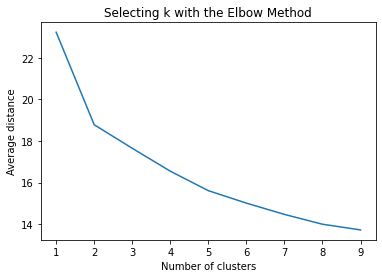

In [88]:
clusters=range(1,10)
meandist=[]

data_test = test_encodedframe
# loop through each cluster and fit the model to the train set
# generate the predicted cluster assingment and append the mean 
# distance my taking the sum divided by the shape
for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(data_test)
    clusassign=model.predict(data_test)
    meandist.append(sum(np.min(cdist(data_test, model.cluster_centers_, 'euclidean'), axis=1))
    / data_test.shape[0])

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method') 

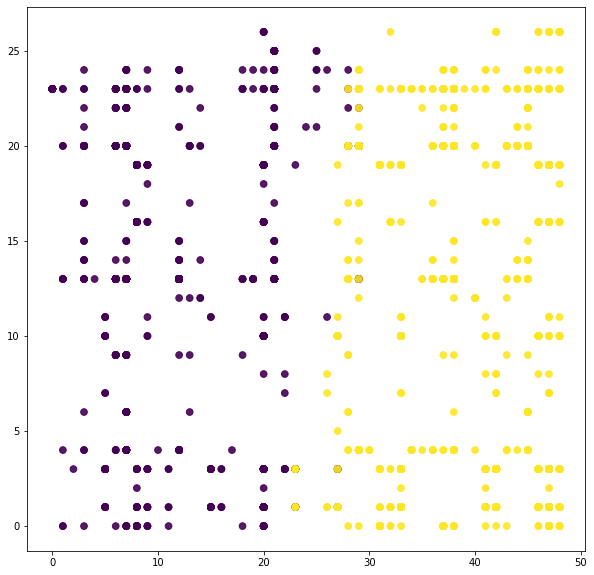

In [89]:
k = KMeans(n_clusters=2, random_state=0)
kfit = k.fit(data_test)
kpred = kfit.predict(data_test)
plt.figure(figsize=(10,10))
plt.scatter(data_test.values[:, 0], data_test.values[:, 1], c=kpred, s=45, alpha=0.9)

In [91]:
test_encodedframe['KLabels'] = pd.Series(kpred, index=test_encodedframe.index)
test_encodedframe['ID'] = df_test['ID']

In [92]:
test_label = []
for x in range(2):
    test_label.append(test_encodedframe.loc[test_encodedframe['KLabels']==x])

In [97]:
test_clabel = []
for frame in test_label:
    cframe = pd.DataFrame()
    for column in frame:
        if len((frame[column].value_counts())) == 1:
            print('not_ok')
        else:
#           print('ok')
            cframe = pd.concat([cframe,frame[column]],axis=1)
    test_clabel.append(cframe)  

not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok
not_ok


In [103]:
test_clabel[0] = test_clabel[0].drop(['ID'],axis=1)
test_clabel[1] = test_clabel[1].drop(['ID'],axis=1)

In [104]:
test_clabel[0]

,0,1,2,3,5,6,7,8,9,10,...,364,365,366,367,368,369,370,371,372,373
0,21,23,34,5,26,0,22,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,21,23,17,5,0,9,9,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,21,13,34,5,31,11,13,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,12,13,38,2,14,9,13,0,0,0,...,0,1,0,0,0,0,0,0,0,0
10,12,13,38,2,13,3,13,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4198,7,6,17,0,1,9,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4199,8,16,27,5,1,3,6,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4200,8,19,26,5,1,11,20,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4204,6,9,17,5,1,9,4,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [154]:
x1 = label[0].iloc[:,:-3]
y1 = label[0]['y']

In [155]:
test_x1 = test_label[0].iloc[:,:-2]

In [156]:
x2 = label[1].iloc[:,:-3]
y2 = label[1]['y']

In [157]:
test_x2 = test_label[1].iloc[:,:-2]

In [163]:
x_train, x_valid, y_train, y_valid = train_test_split(x2, y2, test_size=0.2, random_state=4242)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(test_x2)

params = {}
params['objective'] = 'reg:squarederror'
params['eta'] = 0.02
params['max_depth'] = 4

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True, verbose_eval=10)

[0]	train-rmse:100.853	valid-rmse:99.7036	train-r2:-54.8829	valid-r2:-54.6936
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:82.5704	valid-rmse:81.5762	train-r2:-36.4584	valid-r2:-36.283
[20]	train-rmse:67.6509	valid-rmse:66.7798	train-r2:-24.1447	valid-r2:-23.9847
[30]	train-rmse:55.4862	valid-rmse:54.7138	train-r2:-15.915	valid-r2:-15.7717
[40]	train-rmse:45.5807	valid-rmse:44.886	train-r2:-10.4146	valid-r2:-10.2877
[50]	train-rmse:37.53	valid-rmse:36.8959	train-r2:-6.73853	valid-r2:-6.62675
[60]	train-rmse:31.0028	valid-rmse:30.4165	train-r2:-4.28084	valid-r2:-4.18325
[70]	train-rmse:25.731	valid-rmse:25.1978	train-r2:-2.63759	valid-r2:-2.55721
[80]	train-rmse:21.489	valid-rmse:21.0132	train-r2:-1.53707	valid-r2:-1.47383
[90]	train-rmse:18.0946	valid-rmse:17.6706	train-r2:-0.798867	valid-r2:-0.74938
[100]	train-rmse:15.4031	valid-rmse:15.0306	train-r2:-0.303512	valid-r2:-0.2

In [164]:
p_test = clf.predict(d_test)

In [162]:
p_test.shape

(1526,)

In [165]:
0.68+0.44

1.12

In [166]:
1.12/2

0.56